<a href="https://colab.research.google.com/github/eddylim95/CZ4042_NeuralNet_project/blob/master/Assignment_2/start_project_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For google colab use
%tensorflow_version 1.x
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/My Drive/CZ4042_NeuralNet_project'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/CZ4042_NeuralNet_project


In [0]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'Assignment_2'))
	print(os.getcwd())
except:
	pass

import numpy as np
import pandas
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import time
from tqdm import tqdm_notebook as tqdm

MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

HIDDEN_SIZE = 20
MAX_LABEL = 15
EMBEDDING_SIZE = 20

batch_size = 128
no_epochs = 100
lr = 0.01

tf.logging.set_verbosity(tf.logging.ERROR)
seed = 10
tf.set_random_seed(seed)

def cnn_model(x, model_type, dropout=False):
    if model_type == 'char':
        input_layer = tf.reshape(
            tf.one_hot(x, 256), [-1, MAX_DOCUMENT_LENGTH, 256, 1])

        # if dropout:
        #     input_layer = tf.layers.dropout(input_layer, 0.1)

        with tf.variable_scope('Char_CNN_Layer1'):
            conv1 = tf.layers.conv2d(
                input_layer,
                filters=N_FILTERS,
                kernel_size=FILTER_SHAPE1,
                padding='VALID',
                activation=tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(
                conv1,
                pool_size=POOLING_WINDOW,
                strides=POOLING_STRIDE,
                padding='SAME')
            if dropout:
                pool1 = tf.layers.dropout(pool1, 0.25)
        with tf.variable_scope('Char_CNN_Layer2'):
            conv2 = tf.layers.conv2d(
                pool1,
                filters=N_FILTERS,
                kernel_size=FILTER_SHAPE2,
                padding='VALID',
                activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(
                conv2,
                pool_size=POOLING_WINDOW,
                strides=POOLING_STRIDE,
                padding='SAME')
            if dropout:
                pool2 = tf.layers.dropout(pool2, 0.25)

        pool2 = tf.squeeze(tf.reduce_max(pool2, 1), squeeze_dims=[1])

        logits = tf.layers.dense(pool2, MAX_LABEL, activation=None)

        # if dropout:
        #     logits = tf.layers.dropout(logits, 0.5)

        return input_layer, logits
    
    elif model_type == 'word':
        word_vectors = tf.contrib.layers.embed_sequence(
        x, vocab_size=n_words, embed_dim=EMBEDDING_SIZE)
        
        word_list = tf.unstack(word_vectors, axis=1)

        input_layer = tf.reshape(
            word_vectors, [-1, MAX_DOCUMENT_LENGTH, HIDDEN_SIZE, 1])
        # if dropout:
        #     input_layer = tf.layers.dropout(input_layer, 0.1)

        with tf.variable_scope('Word_CNN_Layer1'):
            conv1 = tf.layers.conv2d(
                input_layer,
                filters=N_FILTERS,
                kernel_size=[20, 20],
                padding='VALID',
                activation=tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(
                conv1,
                pool_size=POOLING_WINDOW,
                strides=POOLING_STRIDE,
                padding='SAME')
            if dropout:
                pool1 = tf.layers.dropout(pool1, 0.25)
        with tf.variable_scope('Word_CNN_Layer2'):
            conv2 = tf.layers.conv2d(
                pool1,
                filters=N_FILTERS,
                kernel_size=FILTER_SHAPE2,
                padding='VALID',
                activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(
                conv2,
                pool_size=POOLING_WINDOW,
                strides=POOLING_STRIDE,
                padding='SAME')
            if dropout:
                pool2 = tf.layers.dropout(pool2, 0.25)

        pool2 = tf.squeeze(tf.reduce_max(pool2, 1), squeeze_dims=[1])

        logits = tf.layers.dense(pool2, MAX_LABEL, activation=None)

        # if dropout:
        #     logits = tf.layers.dropout(logits, 0.5)

        return input_layer, logits
    else:
        raise Exception(f'No model type named {model_type}')

def rnn_model(x, model_type, cell_type='GRU', num_layers=1, dropout=False):
    if model_type == 'char':
        input_layer = tf.one_hot(x, 256)
        input_layer = tf.unstack(input_layer, axis=1)

        cells_ = []
        for i in range(num_layers):
            # Define cell type
            if cell_type == 'GRU':
                cell = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE, reuse=tf.get_variable_scope().reuse)
            elif cell_type == 'VANILLA':
                cell = tf.nn.rnn_cell.BasicRNNCell(HIDDEN_SIZE, reuse=tf.get_variable_scope().reuse)
            elif cell_type == 'LSTM':
                cell = tf.nn.rnn_cell.LSTMCell(HIDDEN_SIZE, reuse=tf.get_variable_scope().reuse)
            else:
                raise Exception(f'No cell type matches {cell_type}')

            # Define dropout
            if dropout:
                cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)

            cells_.append(cell)

        # Multi-layer rnn cells
        cells = tf.nn.rnn_cell.MultiRNNCell(cells_)
        _, encoding = tf.nn.static_rnn(cells, input_layer, dtype=tf.float32)

        encoding = np.array(encoding).flatten()

        # Dense layer
        logits = tf.layers.dense(encoding[-1], MAX_LABEL, activation=None)
        # if dropout:
        #     logits = tf.layers.dropout(logits, 0.5)

        return input_layer, logits

    elif model_type == 'word':
        word_vectors = tf.contrib.layers.embed_sequence(
            x, vocab_size=n_words, embed_dim=EMBEDDING_SIZE)

        word_list = tf.unstack(word_vectors, axis=1)

        cells_ = []
        for i in range(num_layers):
            # Define cell type
            if cell_type == 'GRU':
                cell = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE, reuse=tf.get_variable_scope().reuse)
            elif cell_type == 'VANILLA':
                cell = tf.nn.rnn_cell.BasicRNNCell(HIDDEN_SIZE, reuse=tf.get_variable_scope().reuse)
            elif cell_type == 'LSTM':
                cell = tf.nn.rnn_cell.LSTMCell(HIDDEN_SIZE, reuse=tf.get_variable_scope().reuse)
            else:
                raise Exception(f'No cell type matches {cell_type}')

            # Define dropout
            if dropout:
                cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)

            cells_.append(cell)

        # Multi-layer rnn cells
        cells = tf.nn.rnn_cell.MultiRNNCell(cells_)
        _, encoding = tf.nn.static_rnn(cells, word_list, dtype=tf.float32)

        encoding = np.array(encoding).flatten()

        # Dense layer
        logits = tf.layers.dense(encoding[-1], MAX_LABEL, activation=None)

        # if dropout:
        #     logits = tf.layers.dropout(logits, 0.5)

        return word_list, logits
    else:
        raise Exception(f'No model type named {model_type}')

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []

    with open('train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            x_train.append(row[2])
            y_train.append(int(row[0]))

    with open('test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            x_test.append(row[2])
            y_test.append(int(row[0]))

    x_train = pandas.Series(x_train)
    y_train = pandas.Series(y_train)
    x_test = pandas.Series(x_test)
    y_test = pandas.Series(y_test)

    char_processor = tf.contrib.learn.preprocessing.ByteProcessor(MAX_DOCUMENT_LENGTH)
    x_train = np.array(list(char_processor.fit_transform(x_train)))
    x_test = np.array(list(char_processor.transform(x_test)))
    y_train = y_train.values
    y_test = y_test.values

    return x_train, y_train, x_test, y_test

def data_read_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    
    with open('train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            x_train.append(row[2])
            y_train.append(int(row[0]))

    with open("test_medium.csv", encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            x_test.append(row[2])
            y_test.append(int(row[0]))
    
    x_train = pandas.Series(x_train)
    y_train = pandas.Series(y_train)
    x_test = pandas.Series(x_test)
    y_test = pandas.Series(y_test)
    y_train = y_train.values
    y_test = y_test.values
    
    vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
        MAX_DOCUMENT_LENGTH)

    x_transform_train = vocab_processor.fit_transform(x_train)
    x_transform_test = vocab_processor.transform(x_test)

    x_train = np.array(list(x_transform_train))
    x_test = np.array(list(x_transform_test))

    no_words = len(vocab_processor.vocabulary_)
    print('Total words: %d' % no_words)

    return x_train, y_train, x_test, y_test, no_words

def plot_acc(filename: str, epochs: int, test_acc: list, dropout_acc=[]):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    ax.plot(range(epochs), test_acc, label=f'Test accuracy')
    if dropout_acc != []:
        ax.plot(range(epochs), dropout_acc, label=f'Test accuracy with dropout')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_cost(filename: str, epochs: int, train_cost: list, dropout_cost=[]):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    ax.plot(range(epochs), train_cost, label=f'Train cost')
    if dropout_cost != []:
        ax.plot(range(epochs), dropout_cost, label=f'Train cost with dropout')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_all_acc(filename: str, epochs: int, accuracies: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    labels = ['GRU', 'RNN', 'LSTM', '2-layer GRU', 'GRU with gradient clipping']
    for i,accuracy in enumerate(accuracies):
        ax.plot(range(epochs), accuracy, label=f'Test accuracy for {labels[i]}')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_all_cost(filename: str, epochs: int, costs: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    labels = ['GRU', 'RNN', 'LSTM', '2-layer GRU', 'GRU with gradient clipping']
    for i,cost in enumerate(costs):
        ax.plot(range(epochs), cost, label=f'Train cost for {labels[i]}')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()


(5600, 100)
(700, 100)


iter: 0, entropy: 2.25054
iter: 10, entropy: 0.403999
iter: 20, entropy: 0.161609
iter: 30, entropy: 0.227146
iter: 40, entropy: 0.00479834
iter: 50, entropy: 0.00182401
iter: 60, entropy: 0.00103714
iter: 70, entropy: 0.000835788
iter: 80, entropy: 0.000801431
iter: 90, entropy: 0.000518706
45.564372539520264


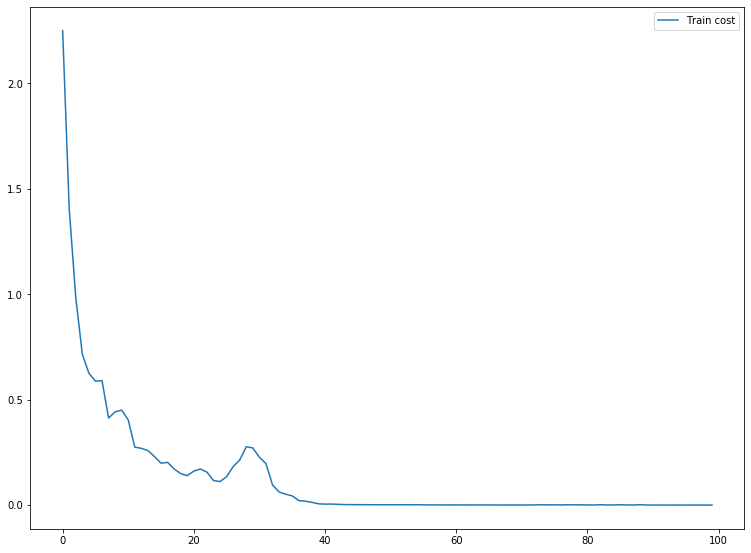

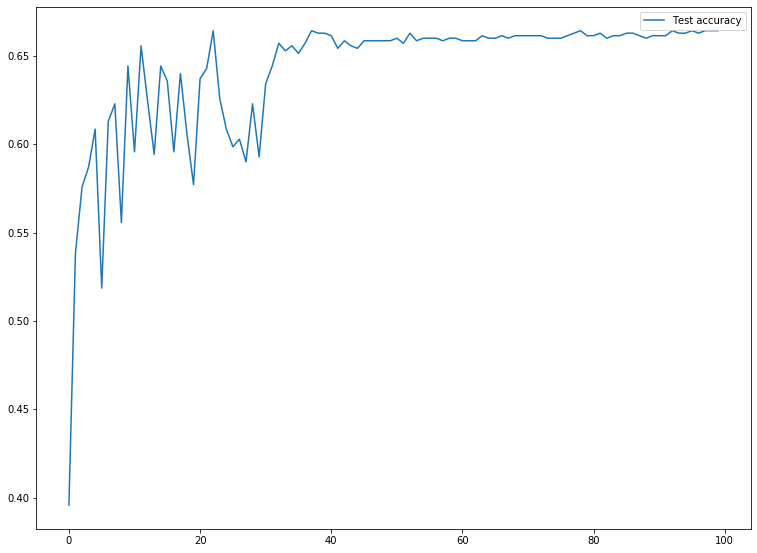

iter: 0, entropy: 2.18153
iter: 10, entropy: 0.129034
iter: 20, entropy: 0.00786818
iter: 30, entropy: 0.00115629
iter: 40, entropy: 0.000667432
iter: 50, entropy: 0.00043458
iter: 60, entropy: 0.000299781
iter: 70, entropy: 0.000213769
iter: 80, entropy: 0.000155622
iter: 90, entropy: 0.000115117
45.14052367210388


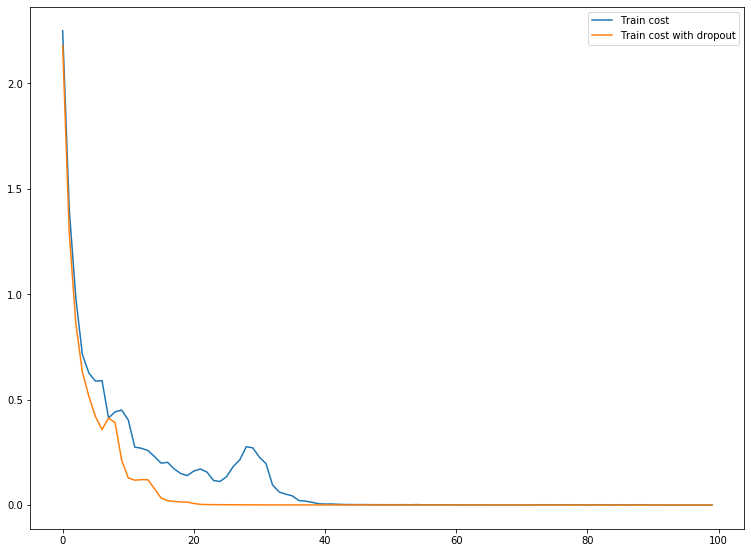

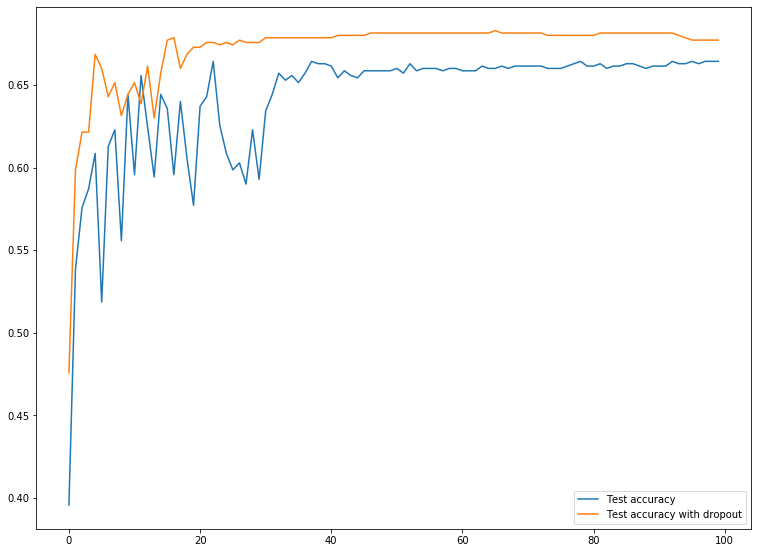

In [0]:
# Q1
x_train, y_train, x_test, y_test = read_data_chars()

print(np.array(x_train).shape)
print(np.array(x_test).shape)

tf.reset_default_graph()

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

inputs, logits = cnn_model(x, model_type='char')

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss = []
test_acc = []
time_taken = 0
# training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Time
    start_time = time.time()
    for e in tqdm(range(no_epochs)):
        loss_ = []
        # Handle in batches
        for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
            _, batch_cost = sess.run([train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
            loss_.append(batch_cost)
        loss.append(np.mean(np.array(loss_), axis=0))
        test_acc.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

        if e%10 == 0:
            print('iter: %d, entropy: %g'%(e, loss[e]))
    time_taken = time.time() - start_time

print(time_taken)
plot_cost('partB_plots/q1_1.png', no_epochs, loss)
plot_acc('partB_plots/q1_2.png', no_epochs, test_acc)

# With dropout
# Create the model
tf.reset_default_graph()
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

inputs, logits = cnn_model(x, model_type='char', dropout=True)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss_dropout = []
test_acc_dropout = []
time_taken = 0
# training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Time
    start_time = time.time()
    for e in tqdm(range(no_epochs)):
        loss_ = []
        # Handle in batches
        for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
            _, batch_cost = sess.run([train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
            loss_.append(batch_cost)
        loss_dropout.append(np.mean(np.array(loss_), axis=0))
        test_acc_dropout.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

        if e%10 == 0:
            print('iter: %d, entropy: %g'%(e, loss_dropout[e]))
    time_taken = time.time() - start_time

print(time_taken)
plot_cost('partB_plots/q1_3.png', no_epochs, loss, loss_dropout)
plot_acc('partB_plots/q1_4.png', no_epochs, test_acc, test_acc_dropout)

Total words: 38658


epoch: 0, entropy: 2.27242
epoch: 10, entropy: 0.000414827
epoch: 20, entropy: 0.000118608
epoch: 30, entropy: 5.38052e-05
epoch: 40, entropy: 2.95391e-05
epoch: 50, entropy: 1.8219e-05
epoch: 60, entropy: 1.20384e-05
epoch: 70, entropy: 8.31143e-06
epoch: 80, entropy: 5.92369e-06
epoch: 90, entropy: 4.31965e-06
25.03600001335144


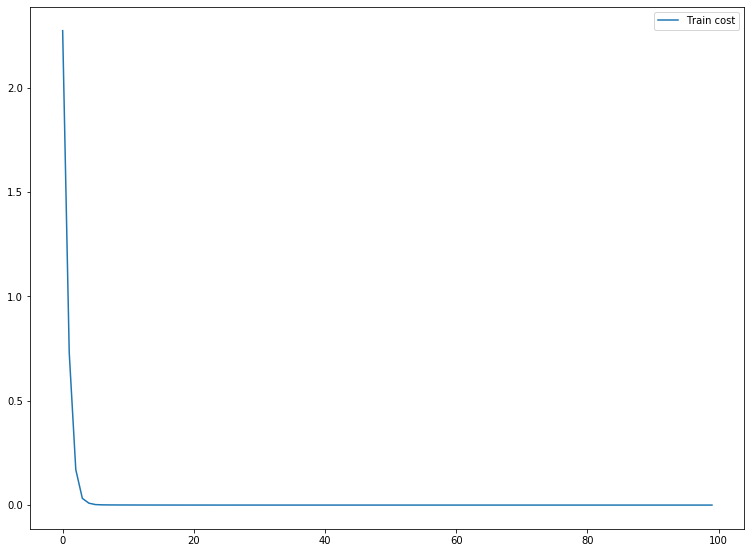

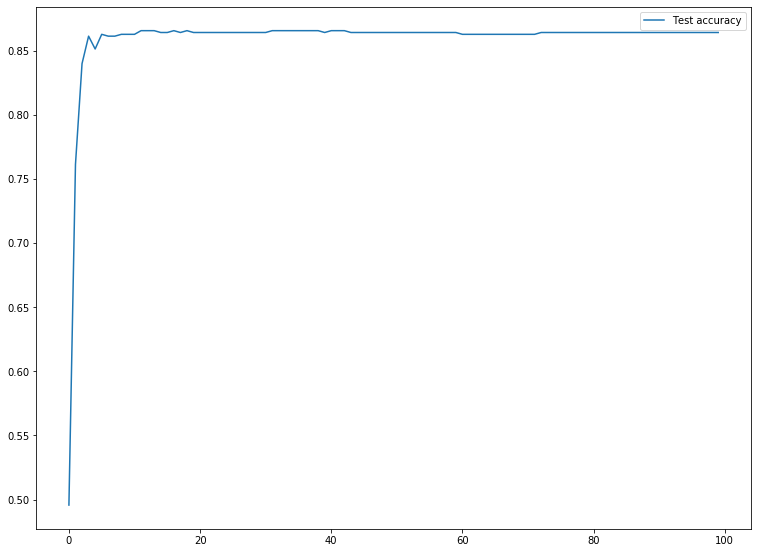

epoch: 0, entropy: 2.19313
epoch: 10, entropy: 0.00029139
epoch: 20, entropy: 8.84152e-05
epoch: 30, entropy: 4.2877e-05
epoch: 40, entropy: 2.47546e-05
epoch: 50, entropy: 1.56593e-05
epoch: 60, entropy: 1.05097e-05
epoch: 70, entropy: 7.34586e-06
epoch: 80, entropy: 5.27806e-06
epoch: 90, entropy: 3.87485e-06
25.484893321990967


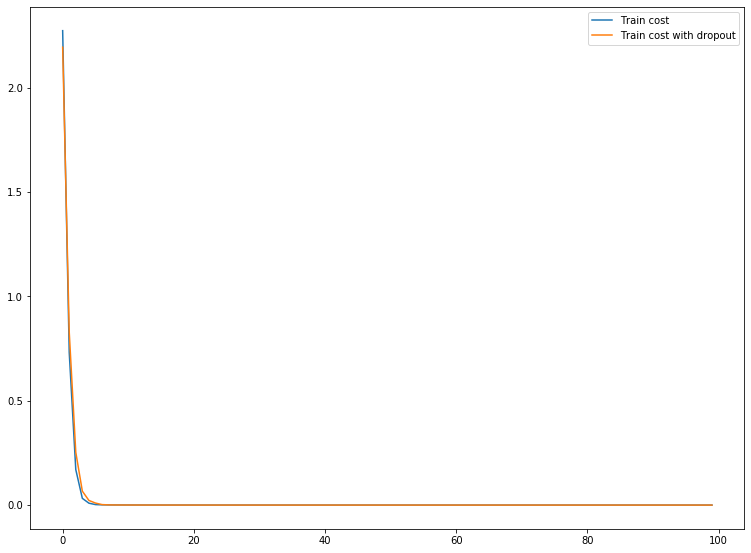

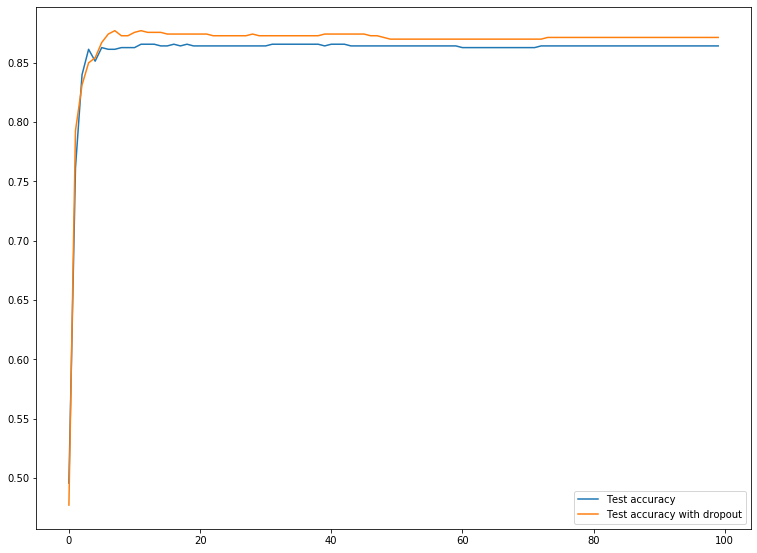

In [0]:
# Q2
global n_words

x_train, y_train, x_test, y_test, n_words = data_read_words()

tf.reset_default_graph()

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

word_list, logits = cnn_model(x, model_type='word')

entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss = []
test_acc = []
time_taken = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Time
    start_time = time.time()
    # training
    for e in tqdm(range(no_epochs)):
        loss_ = []
        # Handle in batches
        for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
            word_list_, _, batch_cost = sess.run([word_list, train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
            loss_.append(batch_cost)
        loss.append(np.mean(np.array(loss_), axis=0))
        test_acc.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

        if e%10 == 0:
            print('epoch: %d, entropy: %g'%(e, loss[e]))

    time_taken = time.time() - start_time

print(time_taken)
plot_cost('partB_plots/q2_1.png', no_epochs, loss)
plot_acc('partB_plots/q2_2.png', no_epochs, test_acc)

# With dropout
# Create the model
tf.reset_default_graph()
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

word_list, logits = cnn_model(x, model_type='word', dropout=True)

entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss_dropout = []
test_acc_dropout = []
time_taken = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Time
    start_time = time.time()
    # training
    for e in tqdm(range(no_epochs)):
        loss_ = []
        # Handle in batches
        for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
            word_list_, _, batch_cost = sess.run([word_list, train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
            loss_.append(batch_cost)
        loss_dropout.append(np.mean(np.array(loss_), axis=0))
        test_acc_dropout.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

        if e%10 == 0:
            print('epoch: %d, entropy: %g'%(e, loss_dropout[e]))

    time_taken = time.time() - start_time

print(time_taken)
plot_cost('partB_plots/q2_3.png', no_epochs, loss, loss_dropout)
plot_acc('partB_plots/q2_4.png', no_epochs, test_acc, test_acc_dropout)

(5600, 100)
(700, 100)


iter: 0, entropy: 2.63606
iter: 10, entropy: 0.796142
iter: 20, entropy: 0.506062
iter: 30, entropy: 0.317557
iter: 40, entropy: 0.266695
iter: 50, entropy: 0.19756
iter: 60, entropy: 0.159147
iter: 70, entropy: 0.104249
iter: 80, entropy: 0.115267
iter: 90, entropy: 0.139575
202.9672429561615


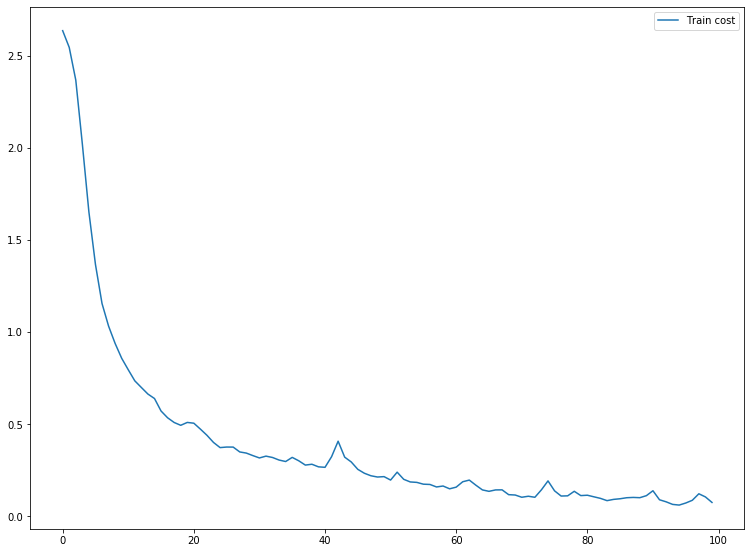

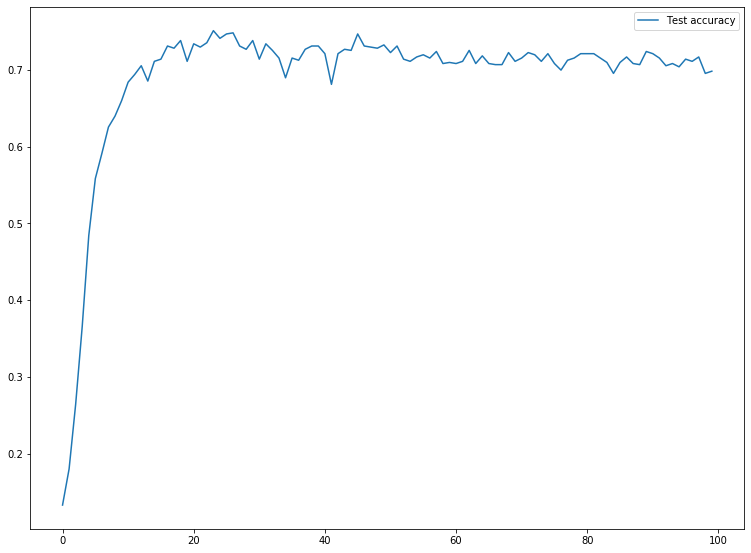

iter: 0, entropy: 2.62596
iter: 10, entropy: 1.00558
iter: 20, entropy: 0.60663
iter: 30, entropy: 0.412183
iter: 40, entropy: 0.294841
iter: 50, entropy: 0.223011
iter: 60, entropy: 0.28314
iter: 70, entropy: 0.132865
iter: 80, entropy: 0.10299
iter: 90, entropy: 0.180808
203.7709379196167


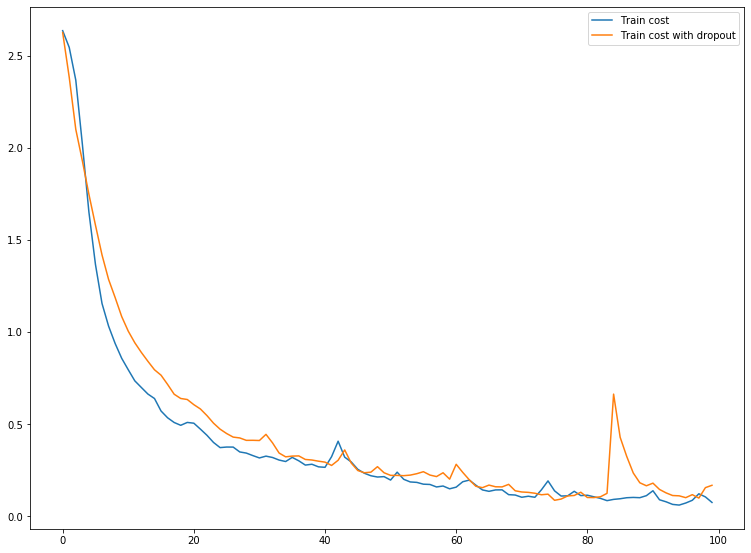

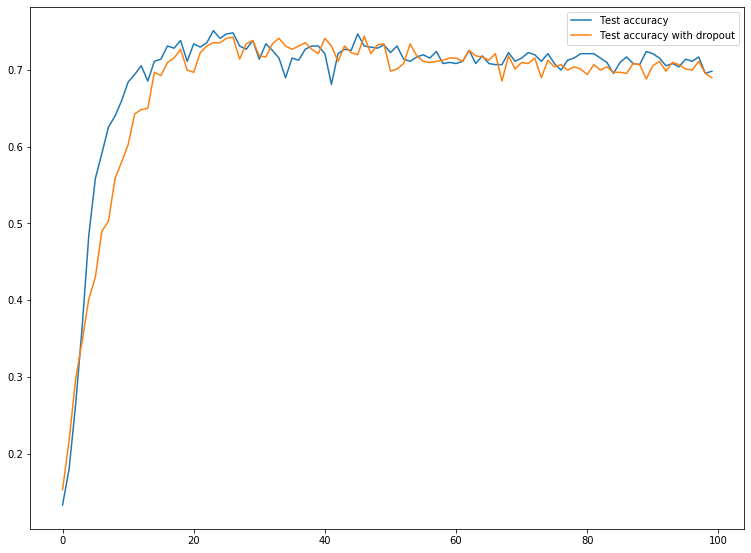

In [0]:
# Q3
x_train, y_train, x_test, y_test = read_data_chars()

print(np.array(x_train).shape)
print(np.array(x_test).shape)

tf.reset_default_graph()

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

inputs, logits = rnn_model(x, model_type='char')

entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss = []
test_acc = []
time_taken = 0
# training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Time
    start_time = time.time()
    # training
    for e in tqdm(range(no_epochs)):
        loss_ = []
        # Handle in batches
        for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
            _, batch_cost = sess.run([train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
            loss_.append(batch_cost)
        loss.append(np.mean(np.array(loss_), axis=0))
        test_acc.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

        if e%10 == 0:
            print('iter: %d, entropy: %g'%(e, loss[e]))
    time_taken = time.time() - start_time

print(time_taken)
plot_cost('partB_plots/q3_1.png', no_epochs, loss)
plot_acc('partB_plots/q3_2.png', no_epochs, test_acc)

# With dropout
# Create the model
tf.reset_default_graph()
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

inputs, logits = rnn_model(x, model_type='char', dropout=True)

entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss_dropout = []
test_acc_dropout = []
time_taken = 0
# training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Time
    start_time = time.time()
    # training
    for e in tqdm(range(no_epochs)):
        loss_ = []
        # Handle in batches
        for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
            _, batch_cost = sess.run([train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
            loss_.append(batch_cost)
        loss_dropout.append(np.mean(np.array(loss_), axis=0))
        test_acc_dropout.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

        if e%10 == 0:
            print('iter: %d, entropy: %g'%(e, loss_dropout[e]))
    time_taken = time.time() - start_time

print(time_taken)
plot_cost('partB_plots/q3_3.png', no_epochs, loss, loss_dropout)
plot_acc('partB_plots/q3_4.png', no_epochs, test_acc, test_acc_dropout)

Total words: 38658


epoch: 0, entropy: 2.66911
epoch: 10, entropy: 0.0196246
epoch: 20, entropy: 0.00649063
epoch: 30, entropy: 0.0011831
epoch: 40, entropy: 0.000622315
epoch: 50, entropy: 0.000386775
epoch: 60, entropy: 0.00026043
epoch: 70, entropy: 0.000183872
epoch: 80, entropy: 0.000134044
epoch: 90, entropy: 0.000100001
265.8639109134674


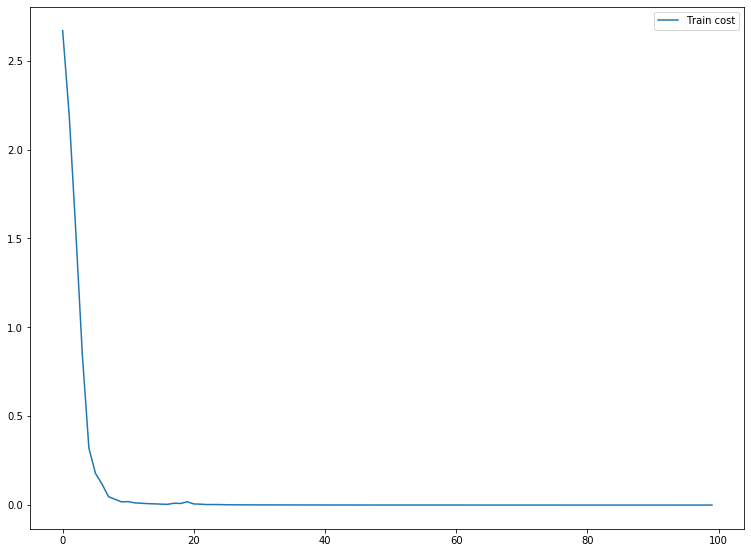

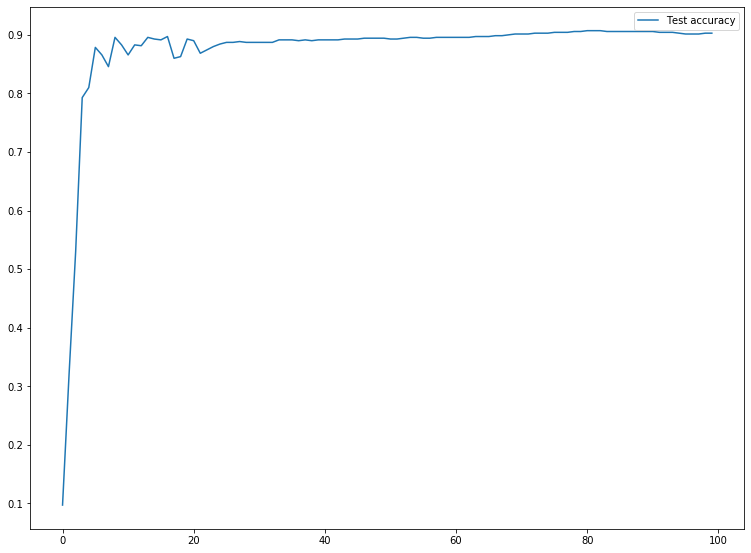

epoch: 0, entropy: 2.67288
epoch: 10, entropy: 0.0188355
epoch: 20, entropy: 0.00200801
epoch: 30, entropy: 0.000948947
epoch: 40, entropy: 0.000554078
epoch: 50, entropy: 0.000358116
epoch: 60, entropy: 0.000245771
epoch: 70, entropy: 0.000175412
epoch: 80, entropy: 0.000128676
epoch: 90, entropy: 9.62683e-05
269.1380169391632


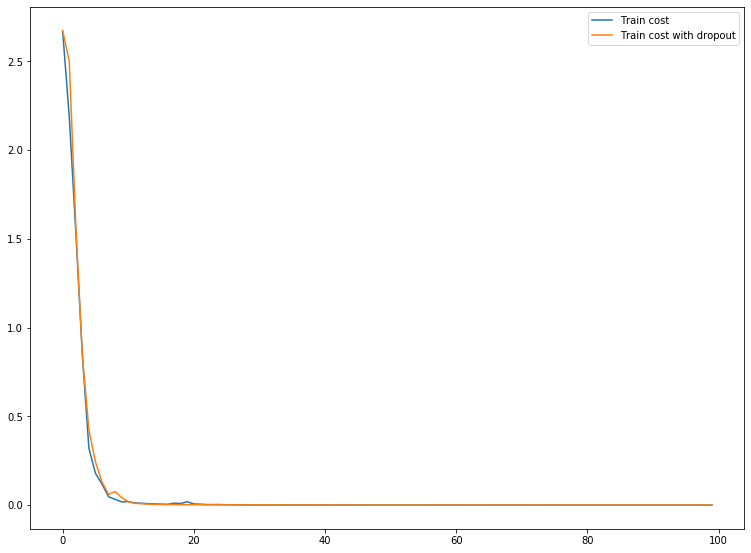

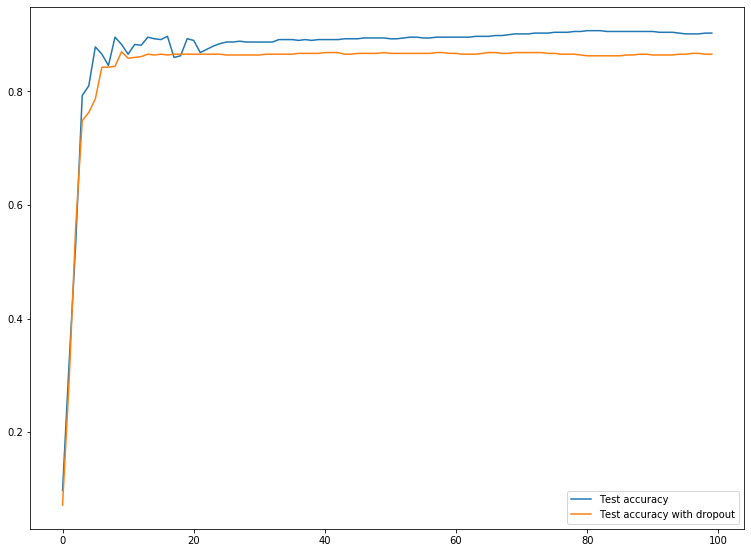

In [0]:
# Q4
global n_words

x_train, y_train, x_test, y_test, n_words = data_read_words()

tf.reset_default_graph()

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

word_list, logits = rnn_model(x, model_type='word')

entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss = []
test_acc = []
time_taken = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Time
    start_time = time.time()
    # training
    for e in tqdm(range(no_epochs)):
        loss_ = []
        # Handle in batches
        for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
            word_list_, _, batch_cost = sess.run([word_list, train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
            loss_.append(batch_cost)
        loss.append(np.mean(np.array(loss_), axis=0))
        test_acc.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

        if e%10 == 0:
            print('epoch: %d, entropy: %g'%(e, loss[e]))

    time_taken = time.time() - start_time

print(time_taken)
plot_cost('partB_plots/q4_1.png', no_epochs, loss)
plot_acc('partB_plots/q4_2.png', no_epochs, test_acc)

# With dropout
# Create the model
tf.reset_default_graph()
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

word_list, logits = rnn_model(x, model_type='word', dropout=True)

entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss_dropout = []
test_acc_dropout = []
time_taken = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Time
    start_time = time.time()
    # training
    for e in tqdm(range(no_epochs)):
        loss_ = []
        # Handle in batches
        for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
            word_list_, _, batch_cost = sess.run([word_list, train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
            loss_.append(batch_cost)
        loss_dropout.append(np.mean(np.array(loss_), axis=0))
        test_acc_dropout.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

        if e%10 == 0:
            print('epoch: %d, entropy: %g'%(e, loss_dropout[e]))

    time_taken = time.time() - start_time

print(time_taken)
plot_cost('partB_plots/q4_3.png', no_epochs, loss, loss_dropout)
plot_acc('partB_plots/q4_4.png', no_epochs, test_acc, test_acc_dropout)

In [67]:
# Q6

comparisons = [
               {'cell_type': 'GRU', 'num_layers': 1, 'grad_clip': False},
               {'cell_type': 'VANILLA', 'num_layers': 1, 'grad_clip': False},
               {'cell_type': 'LSTM', 'num_layers': 1, 'grad_clip': False},
               {'cell_type': 'GRU', 'num_layers': 2, 'grad_clip': False},
               {'cell_type': 'GRU', 'num_layers': 1, 'grad_clip': True}
               ]

# for char model
x_train, y_train, x_test, y_test = read_data_chars()

print(np.array(x_train).shape)
print(np.array(x_test).shape)

losses = []
accuracies = []
for i,item in enumerate(comparisons):
    tf.reset_default_graph()

    # Create the model
    x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
    y_ = tf.placeholder(tf.int64)

    inputs, logits = rnn_model(x, model_type='char', cell_type=item['cell_type'], num_layers=item['num_layers'])

    # Optimizer
    entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))

    # Gradient clipping
    if item['grad_clip']:
        minimizer = tf.train.AdamOptimizer()
        grads_and_vars = minimizer.compute_gradients(entropy)
        grad_clipping = tf.constant(2.0, name="grad_clipping")
        clipped_grads_and_vars = []
        for grad, var in grads_and_vars:
            clipped_grad = tf.clip_by_value(grad, -grad_clipping, grad_clipping)
            clipped_grads_and_vars.append((clipped_grad, var))
        train_op = minimizer.apply_gradients(clipped_grads_and_vars)
    else:
        train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

    correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    loss = []
    test_acc = []
    time_taken = 0
    # training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # Time
        start_time = time.time()
        for e in tqdm(range(no_epochs)):
            loss_ = []
            # Handle in batches
            for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
                _, batch_cost = sess.run([train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
                loss_.append(batch_cost)
            loss.append(np.mean(np.array(loss_), axis=0))
            test_acc.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

            if e%10 == 0:
                print('iter: %d, entropy: %g'%(e, loss[e]))
    losses.append(loss)
    accuracies.append(test_acc)


(5600, 100)
(700, 100)


iter: 0, entropy: 2.63702
iter: 10, entropy: 0.871292
iter: 20, entropy: 0.550022
iter: 30, entropy: 0.332692
iter: 40, entropy: 0.443893
iter: 50, entropy: 0.224191
iter: 60, entropy: 0.142044
iter: 70, entropy: 0.108086
iter: 80, entropy: 0.117577
iter: 90, entropy: 0.125946


iter: 0, entropy: 2.64374
iter: 10, entropy: 2.48011
iter: 20, entropy: 2.34902
iter: 30, entropy: 2.32864
iter: 40, entropy: 2.46812
iter: 50, entropy: 2.40714
iter: 60, entropy: 2.55636
iter: 70, entropy: 2.46371
iter: 80, entropy: 2.43408
iter: 90, entropy: 2.3792


iter: 0, entropy: 2.63527
iter: 10, entropy: 1.8497
iter: 20, entropy: 0.975944
iter: 30, entropy: 0.663765
iter: 40, entropy: 0.441708
iter: 50, entropy: 0.343971
iter: 60, entropy: 0.236904
iter: 70, entropy: 0.277709
iter: 80, entropy: 0.162014
iter: 90, entropy: 0.115919


iter: 0, entropy: 2.55614
iter: 10, entropy: 0.832219
iter: 20, entropy: 0.481639
iter: 30, entropy: 0.277888
iter: 40, entropy: 0.176338
iter: 50, entropy: 0.168764
iter: 60, entropy: 0.0691729
iter: 70, entropy: 0.0679969
iter: 80, entropy: 0.0495976
iter: 90, entropy: 0.0211822


iter: 0, entropy: 2.6989
iter: 10, entropy: 2.11297
iter: 20, entropy: 1.92169
iter: 30, entropy: 1.8238
iter: 40, entropy: 1.7786
iter: 50, entropy: 1.70759
iter: 60, entropy: 1.67935
iter: 70, entropy: 1.62347
iter: 80, entropy: 1.56972
iter: 90, entropy: 1.53703


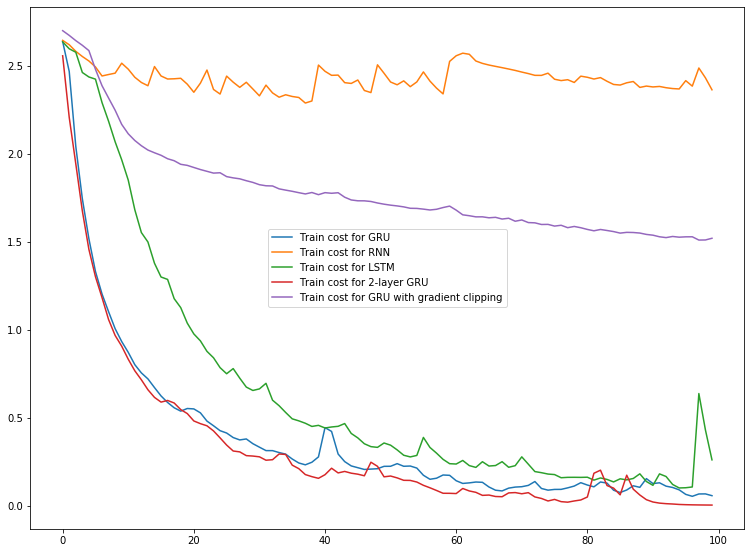

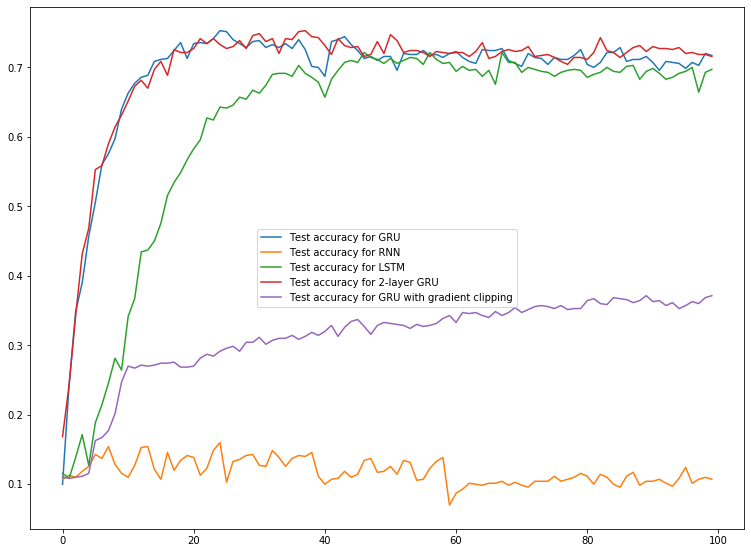

In [68]:
plot_all_cost('partB_plots/q6_1.png', no_epochs, losses)
plot_all_acc('partB_plots/q6_2.png', no_epochs, accuracies)

In [80]:
# Q7
global n_words

x_train, y_train, x_test, y_test, n_words = data_read_words()

word_list, logits = cnn_model(x, model_type='word')
comparisons = [
               {'cell_type': 'GRU', 'num_layers': 1, 'grad_clip': False},
               {'cell_type': 'VANILLA', 'num_layers': 1, 'grad_clip': False},
               {'cell_type': 'LSTM', 'num_layers': 1, 'grad_clip': False},
               {'cell_type': 'GRU', 'num_layers': 2, 'grad_clip': False},
               {'cell_type': 'GRU', 'num_layers': 1, 'grad_clip': True}
               ]

losses_words = []
accuracies_words = []
for i,item in enumerate(comparisons):
    tf.reset_default_graph()
    
    # Create the model
    x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
    y_ = tf.placeholder(tf.int64)

    word_list, logits = rnn_model(x, model_type='char', cell_type=item['cell_type'], num_layers=item['num_layers'])

    # Optimizer
    entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))

    # Gradient clipping
    if item['grad_clip']:
        minimizer = tf.train.AdamOptimizer()
        grads_and_vars = minimizer.compute_gradients(entropy)
        grad_clipping = tf.constant(2.0, name="grad_clipping")
        clipped_grads_and_vars = []
        for grad, var in grads_and_vars:
            clipped_grad = tf.clip_by_value(grad, -grad_clipping, grad_clipping)
            clipped_grads_and_vars.append((clipped_grad, var))
        train_op = minimizer.apply_gradients(clipped_grads_and_vars)
    else:
        train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

    correct_prediction = tf.equal(tf.argmax(logits, 1), y_)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    loss = []
    test_acc = []
    time_taken = 0
    # training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # Time
        start_time = time.time()
        for e in tqdm(range(no_epochs)):
            loss_ = []
            # Handle in batches
            for start, end in zip(range(0, len(x_train), batch_size), range(batch_size, len(x_train), batch_size)):
                word_list_, _, batch_cost = sess.run([word_list, train_op, entropy], {x: x_train[start:end], y_: y_train[start:end]})
                loss_.append(batch_cost)
            loss.append(np.mean(np.array(loss_), axis=0))
            test_acc.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

            if e%10 == 0:
                print('iter: %d, entropy: %g'%(e, loss[e]))
    losses_words.append(loss)
    accuracies_words.append(test_acc)

Total words: 38658


iter: 0, entropy: 2.67008
iter: 10, entropy: 0.815494
iter: 20, entropy: 0.602131
iter: 30, entropy: 0.501636
iter: 40, entropy: 0.411036
iter: 50, entropy: 0.406062
iter: 60, entropy: 0.333237
iter: 70, entropy: 0.303742
iter: 80, entropy: 0.25369
iter: 90, entropy: 0.233961


iter: 0, entropy: 2.66832
iter: 10, entropy: 2.64277
iter: 20, entropy: 2.65181
iter: 30, entropy: 2.64055
iter: 40, entropy: 2.63891
iter: 50, entropy: 2.63885
iter: 60, entropy: 2.55517
iter: 70, entropy: 2.54559
iter: 80, entropy: 2.54138
iter: 90, entropy: 2.55485


iter: 0, entropy: 2.66713
iter: 10, entropy: 2.64278
iter: 20, entropy: 1.03376
iter: 30, entropy: 0.779589
iter: 40, entropy: 0.629797
iter: 50, entropy: 0.553706
iter: 60, entropy: 0.445713
iter: 70, entropy: 0.412736
iter: 80, entropy: 0.37189
iter: 90, entropy: 0.36867


iter: 0, entropy: 2.67011
iter: 10, entropy: 0.933657
iter: 20, entropy: 0.614145
iter: 30, entropy: 0.451124
iter: 40, entropy: 0.403524
iter: 50, entropy: 0.360714
iter: 60, entropy: 0.257365
iter: 70, entropy: 0.225943
iter: 80, entropy: 0.213395
iter: 90, entropy: 0.189929


iter: 0, entropy: 2.69288
iter: 10, entropy: 2.09973
iter: 20, entropy: 1.83804
iter: 30, entropy: 1.62572
iter: 40, entropy: 1.39513
iter: 50, entropy: 1.30297
iter: 60, entropy: 1.22579
iter: 70, entropy: 1.17495
iter: 80, entropy: 1.10288
iter: 90, entropy: 1.04893


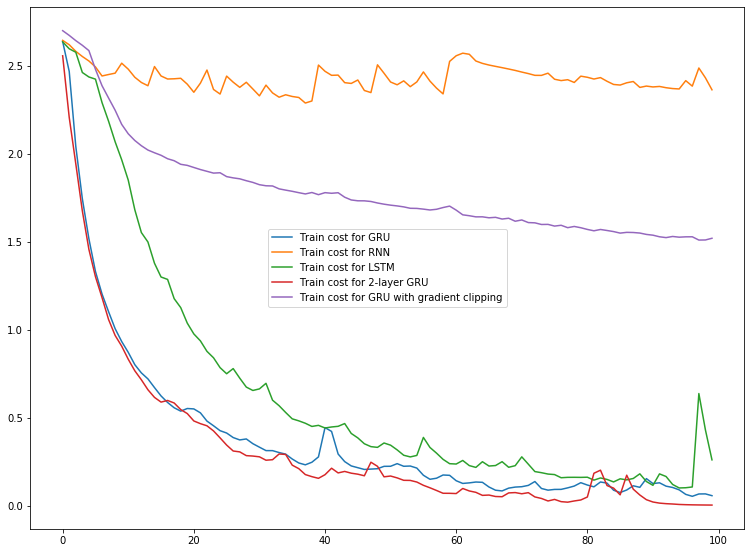

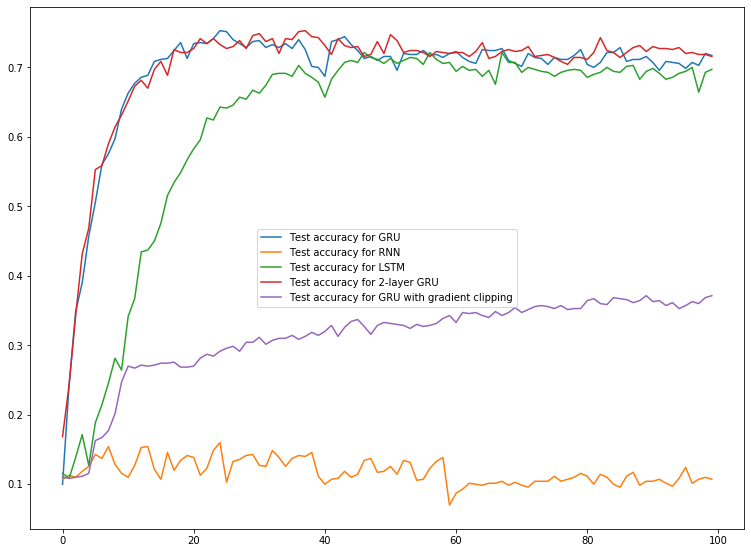

In [81]:
plot_all_cost('partB_plots/q6_3.png', no_epochs, losses)
plot_all_acc('partB_plots/q6_4.png', no_epochs, accuracies)